In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
from colorsys import hls_to_rgb
from PIL import Image
import os
import glob
from utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# System parameters

In [2]:
# size of the region of interest
roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2

# Metric function
Implement the Fourier Ring Correlation in http://doi.org/10.1038/nmeth.2448

# Load data

In [3]:
# Folder containing the images
folder = './sim_data/bprp_abe00/'
generate_matlab_dataset= True
keyword = 'tile'

In [5]:
import scipy.io
# Find all .png files in the folder
files = glob.glob(os.path.join(folder, "*.png"))

img = []
sx = []
sy = []

if generate_matlab_dataset:
    I_low_stack = []
    na_calib = []
    na_cal = fc_lens*lambda_m   # NA without dimension
    na_rp_cal = fc_lens*Dx_m    # NA in pixels

for filename in files:
    img_0 = np.array(Image.open(filename)).astype(float)
    img.append(img_0)
    filename = os.path.basename(filename)
    # sx_0 = float(filename[-17:-12])
    sx_0 = float(filename[-20:-15])
    sy_0 = float(filename[-9:-4])
    sx.append(sx_0)
    sy.append(sy_0)
    if generate_matlab_dataset:
        I_low_stack.append(img_0)
        na_calib.append([sx_0*fc_lens*lambda_m, sy_0*fc_lens*lambda_m])

if generate_matlab_dataset:
    I_low = np.stack(I_low_stack, axis=2)
    na_calib = np.array(na_calib)
    freqXY_calib = na_calib*na_rp_cal/na_cal+roi_size_px/2+1 # Shift to the center of the FOV
    scipy.io.savemat(f'{folder}/{keyword}.mat', {'I_low': I_low, 'freqXY_calib': freqXY_calib, 'na_calib': na_calib,
                                                'na_cal': na_cal, 'na_rp_cal': na_rp_cal})
print(len(img))

60


# Visualize illumination pattern

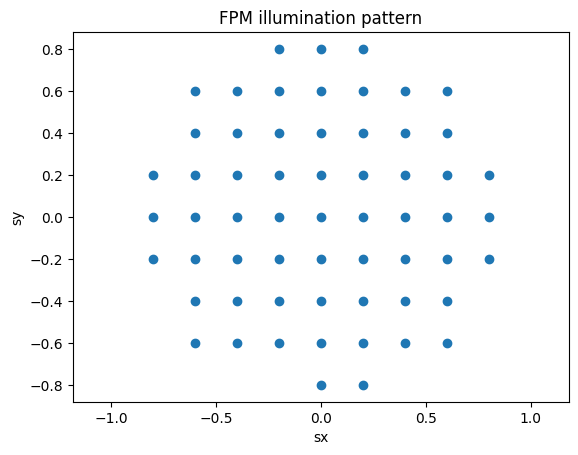

In [8]:
# Creating the scatter plot
plt.scatter(sx, sy)
plt.xlabel('sx')
plt.ylabel('sy')
plt.title('FPM illumination pattern')
# Setting axis limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('equal')

plt.show()

# save as meas pattern for simulation
meas = []
for i in range(len(sx)):
    meas.append([sx[i], sy[i]])
    
import pickle
with open(f'{folder}/meas.pkl', 'wb') as f:
    pickle.dump(meas, f)


# Initialization

In [9]:
def zernike_polynomial(n, m, pupil):
    def polar_coords():
        """Generate polar coordinates for a given size"""
        x = np.linspace(-1, 1, cmax-cmin+1)
        y = np.linspace(-1, 1, rmax-rmin+1)
        X, Y = np.meshgrid(x, y)
        R = np.sqrt(X**2 + Y**2)
        T = np.arctan2(Y, X)
        T = np.where(T < 0, T + 2*np.pi, T)
        return R, T

    def radial_poly(n, m, R):
        """Calculate the radial polynomial"""
        radial = np.zeros_like(R)
        for s in range((n - abs(m)) // 2 + 1):
            coef = (-1)**s * np.math.factorial(n - s)
            coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)
            radial += coef * R**(n - 2 * s)
        return radial

    rows = np.any(pupil, axis=1)
    cols = np.any(pupil, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    R, T = polar_coords()
    Radial = radial_poly(n, m, R)
    if m > 0:
        Z = np.sqrt(2*n+2) * Radial * np.cos(m * T)
    elif m < 0:
        Z = -np.sqrt(2*n+2) * Radial * np.sin(m * T)
    else:
        Z = np.sqrt(n+1) * Radial

    # Pad the Zernike polynomial to match the full pupil size
    padded_Z = np.zeros(pupil.shape)
    padded_Z[rmin:rmax+1, cmin:cmax+1] = Z
    return padded_Z


In [10]:
def get_lens_init(FILTER, option='plane', file_name=""):
    FILTER = np.double(FILTER)
    if option == 'plane':
        lens_init = FILTER
        abe = np.zeros(FILTER.shape)
    elif option == 'zernike':
        defocus_coef = 0.15
        coma_coef = [0.075,0.075]
        defocus = zernike_polynomial(2, 0, FILTER)
        coma1 = zernike_polynomial(3, 1, FILTER)
        coma2 = zernike_polynomial(3, -1, FILTER)
        abe = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER
        lens_guess = FILTER * np.exp(1j*abe)
        lens_init = lens_guess
    elif option == 'file':
        abe = np.load(file_name)
        lens_init = FILTER * np.exp(1j*abe)
    else:
        raise ValueError('option must be either plane, zernike, or file')
    show_aberration(abe, FILTER)
    return lens_init


# Recon parameters

In [ ]:
use_ROI = True
ROI_length = 256
ROI_center =  [int(roi_size_px/2), int(roi_size_px/2-30)]
init_option = 'plane'
file_name = f'{folder}/gt_abe.npy'

In [ ]:
if use_ROI:
    roi_size_px = min(ROI_length, roi_size_px)
    print(f'Using ROI of size {ROI_length}')
    x_m = x_m[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2)]
    y_m = y_m[ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
    img = [i[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), 
             ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)] for i in img]
    Dx_m = x_m.max() - x_m.min()
    dx_m = Dx_m / ROI_length
    fs = 1 / dx_m
    Nfft = len(x_m)
    df = fs / Nfft
    freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
    Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2

lens_init = get_lens_init(FILTER, init_option, file_name)

In [ ]:
def GDUpdate_Multiplication_rank1(O, P, dpsi, Omax, cen, Ps, alpha, beta, step_size):
    Np = np.array(P.shape).ravel()
    cen = cen.ravel()
    n1 = cen - np.floor(Np / 2)
    n2 = n1 + Np - 1
    n1 = n1.astype(int)
    n2 = n2.astype(int)
    O1 = O[n1[0]:n2[0]+1, n1[1]:n2[1]+1]

    O[n1[0]:n2[0]+1, n1[1]:n2[1]+1] += step_size * 1 / np.max(np.abs(P)) * np.abs(P) * np.conj(P) * dpsi / (np.abs(P) ** 2 + alpha)
    P += 1 / Omax * (np.abs(O1) * np.conj(O1)) * dpsi / (np.abs(O1) ** 2 + beta) * Ps

    return O, P


In [ ]:
# Assuming I_low is a 3D numpy array and freqXY_calib is a 2D numpy array provided beforehand
Nx, Ny, Nimg = I_low.shape

enableROI = True  # whether to use ROI in the reconstruction
ROILength = 256  # define the ROI of the reconstruction
ROIcenter = [round(Nx / 2), round(Ny / 2)]
paddingHighRes = 3

x_illumination = freqXY_calib[:, 1]  # note the second column is assigned to x
y_illumination = freqXY_calib[:, 0]  # note the first column is assigned to y
xc = round(Ny / 2)
yc = round(Nx / 2)
x_illumination -= xc
y_illumination -= yc

# crop ROI
if enableROI:
    x_illumination *= ROILength / Nx
    y_illumination *= ROILength / Ny
    I = I_low[ROIcenter[0] - ROILength // 2: ROIcenter[0] + ROILength // 2,
              ROIcenter[1] - ROILength // 2: ROIcenter[1] + ROILength // 2, :]
    Np = ROILength
    X, Y = np.meshgrid(np.arange(1, Np + 1), np.arange(1, Np + 1))
    xc = round(Np / 2)
    yc = round(Np / 2)
else:
    I = I_low
    Np = Nx
    X, Y = np.meshgrid(np.arange(1, Ny + 1), np.arange(1, Nx + 1))
    xc = round(Ny / 2)
    yc = round(Nx / 2)

distanceFromCenter = np.sqrt((X - xc)**2 + (Y - yc)**2)
w_NA = distanceFromCenter <= na_rp_cal * (ROILength / Nx if enableROI else 1)

Ns2 = np.stack((x_illumination, y_illumination), axis=-1)
Ns2 = Ns2.reshape(1, Nimg, 2)
Ns = np.round(Ns2)

N_obj = paddingHighRes * Np
def upsamp(x):
    pad_height = (N_obj - Np[0]) // 2
    pad_width = (N_obj - Np[1]) // 2
    padding = ((pad_height, pad_height), (pad_width, pad_width))
    return np.pad(x, padding, mode='constant')

def downsamp(x, cen, Np):
    start_row = int(cen[0] - Np[0] // 2)
    end_row = int(start_row + Np[0])
    start_col = int(cen[1] - Np[1] // 2)
    end_col = int(start_col + Np[1])
    return x[start_row:end_row, start_col:end_col]

def F(x):
    # Apply 2D FFT on the first two dimensions and then shift the zero-frequency component to the center
    return np.fft.fftshift(np.fft.fft2(x, axes=(0, 1)), axes=(0, 1))

def Ft(x):
    # Unshift the zero-frequency component and then apply 2D inverse FFT on the first two dimensions
    return np.fft.ifft2(np.fft.ifftshift(x, axes=(0, 1)), axes=(0, 1))



In [ ]:
iters = 50
P = np.complex128(w_NA)
Ps = np.complex128(w_NA)
spectrum_guess = F(np.sqrt(I[:,:,0]))
O = upsamp(spectrum_guess)
H0 = np.ones((roi_size_px, roi_size_px))
r0 = 1
alpha = 1
beta = 1000
step_size = 0.1
scale = np.ones((1,Nimg));

Np = np.array(I[:,:,0].shape)
No = Np
cen0 = np.round((No + 1) / 2).astype(int)

Omax = np.abs(O[cen0[0], cen0[1]])
print(Omax)

def row(x):
    return np.ravel(x)


for _ in range(iters):
    for m in range(Nimg):
        # Initialize Psi for corresponding image, ROI determined by cen
        Psi0 = np.zeros((Np[0], Np[1], r0), dtype=np.complex128)
        Psi_scale = np.zeros((Np[0], Np[1], r0), dtype=np.complex128)
        cen = np.zeros((2, r0))
        scale0 = np.zeros(r0)
        for p in range(r0):
            cen[:, p] = cen0 - row(Ns[p, m, :])
            scale0[p] = scale[p, m]
            # Replace downsamp and other MATLAB-specific functions with Python equivalents
            Psi0[:, :, p] = downsamp(O, cen[:, p], Np) * P * H0
            Psi_scale[:, :, p] = np.sqrt(scale0[p]) * Psi0[:, :, p]

        # Measured intensity
        I_mea = np.squeeze(I[:, :, m])

        # Compute field in real space
        psi0 = np.squeeze(Ft(Psi_scale))

        # Estimated intensity w/o correction term
        I_est = np.abs(psi0) ** 2

        # Replace these functions with Python equivalents
        Psi = F(np.sqrt(I_mea / np.squeeze(scale0)) * np.exp(1j * np.angle(psi0)))
        # Projection 2
        dPsi = Psi - np.squeeze(Psi0)
        Omax = np.abs(O[cen0[0], cen0[1]])
        # Lambda function to replace the anonymous function in MATLAB
        H0_replicated = np.squeeze(np.tile(H0, (1, 1, r0)))

        P2 = lambda O, P, dpsi, Omax, cen: GDUpdate_Multiplication_rank1(O, P, dpsi, Omax, cen, Ps, alpha, beta, step_size)
        O, P = P2(O, P, dPsi / H0_replicated, Omax, cen)

In [ ]:
object_guess = Ft(O)
plt.imshow(np.abs(object_guess)**2, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('GN Reconstruction')
plt.show()

# G-S

In [ ]:
aberrated_FILTER = lens_init
spectrum_guess = ift(np.sqrt(img[0]))
spectrum_guess = spectrum_guess * FILTER
object_guess = ft(spectrum_guess)
lens_guess = np.double(FILTER)

plt.imshow(np.abs(object_guess)**2, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Low-res measurement')
plt.show()


In [ ]:
N_img = len(img) # assuming img is a list

for k in range(100): # general loop
    for i in range(N_img):
        idx = i

        S_n = object_guess
        S_p = ft(S_n)

        X0 = round(sx[idx]*fc_lens*Dx_m)
        Y0 = round(sy[idx]*fc_lens*Dx_m)

        mask = circshift2(FILTER, X0, Y0)
        aberrated_mask = circshift2(aberrated_FILTER, X0, Y0)
        phi_n = aberrated_mask * S_p
        Phi_n = ift(phi_n)
        Phi_np = np.sqrt(img[idx]) * np.exp(1j*np.angle(Phi_n))
        phi_np = ft(Phi_np) # undo aberration

        # S_p[mask] = phi_np[mask]
        step = np.conj(aberrated_mask)/np.max(np.abs(aberrated_mask)**2)*(phi_np-phi_n)
        S_p[mask] = S_p[mask] + step[mask]
        S_np = ift(S_p)
        object_guess = S_np

        # plt.figure(figsize=(10,10)) # create a new figure in each iteration

        # plt.subplot(221)
        # plt.imshow(np.abs(object_guess), cmap=cm.gray)
        # plt.title('Reconstructed amplitude')
        # plt.axis('off')

        # plt.subplot(222)
        # plt.imshow(np.angle(object_guess), cmap=cm.gray)
        # plt.axis('off')
        # plt.title('Reconstructed phase')

        # plt.subplot(223)
        # plt.imshow(np.abs(ft(img[idx]))**0.1, cmap=cm.gray)
        # plt.title('Current image PSD')
        # plt.axis('off')

        # plt.subplot(224)
        # plt.imshow(np.abs(ft(S_np))**0.1, cmap=cm.gray)
        # plt.title('Reconstructed angular spectrum')
        # plt.axis('off')

        # display(plt.gcf()) # display the current figure
        # clear_output(wait = True) # clear the output of the current cell receiving output
        # plt.pause(0.01) # pause for a short time
        
GS_recon = object_guess
GS_recon_image = np.abs(object_guess)**2


In [ ]:
plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Reconstructed object', fontsize=12)
plt.colorbar()
plt.show()

plt.imshow(np.abs(object_guess)**2, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('GS reconstruction')
plt.show()

# display the center [256, 256] region, total size roi_size_px
# param_nx = 256
# object_center = object_guess[roi_size_px//2-param_nx//2:roi_size_px//2+param_nx//2, roi_size_px//2-param_nx//2:roi_size_px//2+param_nx//2]
# plt.imshow(np.abs(object_center), cmap='gray')
# plt.axis('off')
# plt.title('GS reconstruction')
# plt.show()

# Perform the refocusing
# defocus_m = -1e-6
# defocus_phase = np.exp(1j*2*np.pi/lambda_m*defocus_m*np.sqrt(1 -(lambda_m*Fx)**2 -(lambda_m*Fy)**2))
# defocus_recon = ift(ft(object_guess) * defocus_phase)
# defocused_image = np.abs(defocus_recon)**2
# plt.imshow(defocused_image, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
# plt.xlabel('x position (nm)')
# plt.ylabel('y position (nm)')
# plt.title('Refocused image')
# plt.colorbar()
# plt.show()

# np.save('./real_data/defocus_recon.npy', defocus_recon)

## Compare with ground truth

In [ ]:
gt_obj = np.load(f'{folder}/gt.npy')
ideal_FILTER = (Fx**2 + Fy**2) <= ((2)*fc_lens)**2
gt_obj = ift(ft(gt_obj)*ideal_FILTER)

plot_gt_cmp(GS_recon, gt_obj, x_m, y_m, freq_cpm, roi_size_px, frc=True)

# EPFR

## Aberration initialization

In [ ]:
# can choose between 'plane', 'zernike', or 'file'
init_option = 'plane'
file_name = f'{folder}/gt_abe.npy'
lens_init = get_lens_init(FILTER, init_option, file_name)

In [ ]:
spectrum_guess = ift(np.sqrt(img[0]))
spectrum_guess = spectrum_guess * FILTER
object_guess = ft(spectrum_guess)
lens_guess = lens_init

alpha = 1
beta = 1

N_img = len(img) # assuming img is a list

for k in range(10): # general loop
    for i in range(N_img):
        idx = i

        S_n = object_guess
        P_n = lens_guess

        X0 = round(sx[idx]*fc_lens*Dx_m)
        Y0 = round(sy[idx]*fc_lens*Dx_m)

        phi_n = P_n * circshift2(ft(S_n), -X0, -Y0)

        Phi_n = ift(phi_n)
        Phi_np = np.sqrt(img[idx]) * np.exp(1j*np.angle(Phi_n))
        phi_np = ft(Phi_np)

        S_np = ift(ft(S_n) + alpha * \
            (np.conj(circshift2(P_n, X0, Y0)) / np.max(np.abs(circshift2(P_n, X0, Y0))**2)) * \
            (circshift2(phi_np, X0, Y0) - circshift2(phi_n, X0, Y0)))

        P_np = P_n + beta * \
            (np.conj(circshift2(ft(S_n), -X0, -Y0)) / np.max(np.abs(circshift2(ft(S_n), -X0, -Y0))**2)) * \
            (phi_np - phi_n)

        object_guess = S_np
        lens_guess = P_np * FILTER

        # plt.figure(figsize=(10,10)) # create a new figure in each iteration

        # plt.subplot(221)
        # plt.imshow(np.abs(object_guess), cmap=cm.gray)
        # plt.title('Reconstructed amplitude')
        # plt.axis('off')

        # plt.subplot(222)
        # plt.imshow(np.angle(object_guess), cmap=cm.gray)
        # plt.axis('off')
        # plt.title('Reconstructed phase')

        # plt.subplot(223)
        # plt.imshow(np.abs(ft(img[idx]))**0.1, cmap=cm.gray)
        # plt.title('Current image PSD')
        # plt.axis('off')

        # plt.subplot(224)
        # plt.imshow(np.abs(ft(S_np))**0.1, cmap=cm.gray)
        # plt.title('Reconstructed angular spectrum')
        # plt.axis('off')

        # display(plt.gcf()) # display the current figure
        # clear_output(wait = True) # clear the output of the current cell receiving output
        # plt.pause(0.01) # pause for a short time


EPFR_recon = object_guess
EPFR_recon_image = np.abs(object_guess)**2

In [ ]:
plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Reconstructed object')
plt.colorbar()
plt.show()

plt.imshow(np.abs(object_guess)**2, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('EPFR reconstruction')
plt.show()

In [ ]:
show_aberration(np.angle(lens_guess), FILTER)
PSF = np.abs(np.fft.fftshift(np.fft.fft2(lens_guess)))**2
def plot_central_region(PSF, x_m, y_m, region_size=2e-6):
    # Extract the central region of the PSF
    x_center = (x_m[-1] + x_m[0]) / 2
    y_center = (y_m[-1] + y_m[0]) / 2
    x_indices = np.where((x_m >= x_center - region_size/2) & (x_m <= x_center + region_size/2))
    y_indices = np.where((y_m >= y_center - region_size/2) & (y_m <= y_center + region_size/2))
    central_PSF = PSF[y_indices[0][0]:y_indices[0][-1]+1, x_indices[0][0]:x_indices[0][-1]+1]

    # Plot the central region
    plt.imshow(central_PSF, extent=[x_m[x_indices[0][0]]*1e6, x_m[x_indices[0][-1]]*1e6, 
                                    y_m[y_indices[0][0]]*1e6, y_m[y_indices[0][-1]]*1e6])
    plt.xlabel('x position (um)')
    plt.ylabel('y position (um)')
    plt.title('Central Region of PSF')
    plt.show()


plot_central_region(PSF, x_m, y_m)

In [ ]:
plot_gt_cmp(EPFR_recon, gt_obj, x_m, y_m, freq_cpm, roi_size_px, frc=True)

## Tile-based recon without overlap

In [ ]:
def epfr_recon(object_guess, lens_guess, img, sx, sy, tile_size, tile_index):
    alpha = 1
    beta = 1
    N_img = len(img) # assuming img is a list
    
    # create tile mask for the target tile
    tile_mask = np.zeros((roi_size_px, roi_size_px))
    tile_mask[tile_index[0]:tile_index[0]+tile_size, tile_index[1]:tile_index[1]+tile_size] = 1
    
    object_guess = object_guess * tile_mask
    for k in range(3): # general loop
        for i in range(N_img):
            idx = i

            S_n = object_guess
            P_n = lens_guess

            X0 = round(sx[idx]*fc_lens*Dx_m)
            Y0 = round(sy[idx]*fc_lens*Dx_m)

            phi_n = P_n * circshift2(ft(S_n), -X0, -Y0)

            Phi_n = ift(phi_n)
            Phi_np = np.sqrt(img[idx]*tile_mask) * np.exp(1j*np.angle(Phi_n))
            phi_np = ft(Phi_np)

            S_np = ift(ft(S_n) + alpha * \
                (np.conj(circshift2(P_n, X0, Y0)) / np.max(np.abs(circshift2(P_n, X0, Y0))**2)) * \
                (circshift2(phi_np, X0, Y0) - circshift2(phi_n, X0, Y0)))

            P_np = P_n + beta * \
                (np.conj(circshift2(ft(S_n), -X0, -Y0)) / np.max(np.abs(circshift2(ft(S_n), -X0, -Y0))**2)) * \
                (phi_np - phi_n)

            object_guess = S_np
            lens_guess = P_np * FILTER
    
    return object_guess, lens_guess


tile_size = 332
spectrum_guess = ift(np.sqrt(img[0]))
spectrum_guess = spectrum_guess * FILTER
object_guess = ft(spectrum_guess)
lens_guess = lens_init
total_recon = np.zeros((roi_size_px, roi_size_px)).astype(complex)
for p in range(3):
    for q in range(3):
        tile_index = [p*tile_size, q*tile_size]
        recon, lens_guess = epfr_recon(object_guess, lens_guess, img, sx, sy, tile_size, tile_index)
        total_recon += recon

np.save(f'{folder}/total_recon.npy', total_recon)

In [ ]:
plot_gt_cmp(total_recon, gt_obj, x_m, y_m, frc=True)

# APIC

In [ ]:
import scipy.io as sio

file_path = glob.glob(f"{folder}/*APIC*.*")
m = sio.loadmat(file_path[0])
apic_recon = m['himMatching']
pupil_recon = m['CTF_abe']
zernike_recon = m['zernikeCoeff']

# flip pupil recon
pupil_recon = np.fliplr(pupil_recon)
pupil_recon = np.flipud(pupil_recon)
print(apic_recon.shape)
apic_recon = apic_recon[::3, ::3]
show_aberration(np.angle(pupil_recon), FILTER)

In [ ]:
show_aberration(np.angle(pupil_recon), FILTER)

In [ ]:
zernike_recon = np.squeeze(np.array(zernike_recon))
print(zernike_recon)
def get_pupil_phase(z, pupil):
    rows = np.any(pupil, axis=1)
    cols = np.any(pupil, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    x = np.linspace(-1, 1, cmax-cmin+1)
    y = np.linspace(-1, 1, rmax-rmin+1)
    X, Y = np.meshgrid(x, y)
    local_pupil = np.where(X**2 + Y**2 <= 1, 1, 0)
    abe_pupil = np.zeros_like(pupil).astype(np.float64)
    abe_pupil[rmin:rmax+1, cmin:cmax+1] = compute_pupil_function(z, len(z)-1, X, Y) * local_pupil
    return abe_pupil

abe = get_pupil_phase(zernike_recon, FILTER)
show_aberration(-abe, FILTER)


Below is code that is not yet cleaned.

## Tile-based recon with overlap

In [ ]:
def epfr_recon(object_guess, lens_guess, img, sx, sy):
    alpha = 1
    beta = 1
    N_img = len(img) # assuming img is a list

    def pad(image):
        return np.pad(image, ((0, roi_size_px - tile_size), (0, roi_size_px - tile_size)), 'constant', constant_values=0)
    def crop(image):
        return image[:tile_size, :tile_size]
    
    # pad images to roi_size_px
    for i in range(N_img):
        img[i] = pad(img[i])
    
    for k in range(3): # general loop
        for i in range(N_img):
            idx = i

            S_n = pad(object_guess)
            P_n = lens_guess

            X0 = round(sx[idx]*fc_lens*Dx_m)
            Y0 = round(sy[idx]*fc_lens*Dx_m)

            phi_n = P_n * circshift2(ft(S_n), -X0, -Y0)

            Phi_n = ift(phi_n)
            Phi_np = np.sqrt(img[idx]) * np.exp(1j*np.angle(Phi_n))
            phi_np = ft(Phi_np)

            S_np = ift(ft(S_n) + alpha * \
                (np.conj(circshift2(P_n, X0, Y0)) / np.max(np.abs(circshift2(P_n, X0, Y0))**2)) * \
                (circshift2(phi_np, X0, Y0) - circshift2(phi_n, X0, Y0)))
            P_np = P_n + beta * \
                (np.conj(circshift2(ft(S_n), -X0, -Y0)) / np.max(np.abs(circshift2(ft(S_n), -X0, -Y0))**2)) * \
                (phi_np - phi_n)
            object_guess = crop(S_np)
            lens_guess = P_np * FILTER
    
    return object_guess, lens_guess

# divide the tiles
# Adjusting the overlap to ensure uniform tile size

tile_size = 255
num_steps = 1 + roi_size_px // tile_size
step_size = (roi_size_px - tile_size) // (num_steps - 1)

overlap = (tile_size * num_steps - roi_size_px) // (num_steps - 1)
step_size = tile_size - overlap

total_size = tile_size * num_steps - overlap * (num_steps - 1)
assert total_size == roi_size_px

tile_stacks = {(i, j): [] for i in range(num_steps) for j in range(num_steps)}

# Crop and organize by tile location
for image in img:
    for i in range(num_steps):
        for j in range(num_steps):
            x_start = i * step_size
            y_start = j * step_size
            tile = image[x_start:x_start+tile_size, y_start:y_start+tile_size]
            tile_stacks[(i, j)].append(tile)


spectrum_guess = ift(np.sqrt(img[0])) 
spectrum_guess = spectrum_guess * FILTER
object_guess = ft(spectrum_guess)
lens_guess = np.complex128(FILTER)
# tile_lens = lens_guess[roi_size_px//4:3*roi_size_px//4, roi_size_px//4:3*roi_size_px//4]
# tile_FILTER = FILTER[roi_size_px//4:3*roi_size_px//4, roi_size_px//4:3*roi_size_px//4]
tiles = []
for i in range(num_steps):
    for j in range(num_steps):
        x_start = i * step_size
        y_start = j * step_size
        tile_object = object_guess[x_start:x_start+tile_size, y_start:y_start+tile_size]
        tile_recon, lens_recon = epfr_recon(tile_object, lens_guess, tile_stacks[(i,j)], sx, sy)
        object_guess[x_start:x_start+tile_size, y_start:y_start+tile_size] = tile_recon
        tiles.append(tile_recon)
        lens_guess = lens_recon
        

plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Tile-based reconstructed object')
plt.colorbar()
plt.show()    

def create_weighted_mask(tile_size):
    """Create a linearly weighted mask for blending."""
    half_size = tile_size // 2
    ramp = np.linspace(0.1, 1, half_size)  # starting from 0.1 to avoid zero weights
    ramp = np.concatenate([ramp, ramp[::-1]])  # mirror the ramp for the other half
    mask = np.outer(ramp, ramp)
    return mask

def stitch_tiles(tiles, num_steps, step_size, N):
    """Stitch tiles together using overlap."""
    mask = create_weighted_mask(tiles[0].shape[0])
    stitched_image = np.complex128(np.zeros((N, N)))
    weight_sum = np.zeros((N, N))

    for i_idx in range(num_steps):
        for j_idx in range(num_steps):
            i = i_idx * step_size
            j = j_idx * step_size
            
            stitched_image[i:i+tile_size, j:j+tile_size] += tiles[i_idx * num_steps + j_idx] * mask
            weight_sum[i:i+tile_size, j:j+tile_size] += mask

    # Normalize by the weights (to handle overlapping regions)
    stitched_image /= weight_sum

    return stitched_image
 
stiched_object = stitch_tiles(tiles, num_steps, step_size, roi_size_px)
plt.imshow(np.abs(stiched_object)**2, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Stitched image')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Tile-based reconstructed object')
plt.colorbar()
plt.show()   

## Compare reconstruction with ground truth
Also plot FRC curve.

In [ ]:
obj_lines = np.load('obj_lines.npy')
ideal_FILTER = (Fx**2 + Fy**2) <= ((1+np.sqrt(2))*fc_lens)**2
object_gt = ift(ft(obj_lines)*ideal_FILTER)

plt.figure(figsize=(10, 10))  # Increase the figure size

plt.subplot(121)
plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Reconstructed object', fontsize=12)

plt.subplot(122)
plt.imshow(imagecc(object_gt), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('Ground truth object (bandlimited)', fontsize=12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase space between subplots
plt.tight_layout()  # Automatically adjust subplot parameters for better fit
plt.show()

plt.figure()
im_guess = np.abs(object_guess)**2
im_gt = np.abs(object_gt)**2
im_guess_normalized = im_guess / np.std(im_guess)
im_gt_normalized = im_gt / np.std(im_gt)

plt.figure()
plt.plot(x_m*1e9, np.abs(im_guess_normalized[160,:]))
plt.plot(x_m*1e9, np.abs(im_gt_normalized[160,:]))
plt.title('Slice 160')
plt.xlabel('x position (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.legend(['image guess', 'ground truth'])
plt.show()

rmse_normalized = np.sqrt(np.sum((im_guess_normalized-im_gt_normalized)**2))/np.sqrt(np.sum(im_gt_normalized**2))
print(np.log(rmse_normalized))

frc_array, halfbit_threshold = frc(im_guess_normalized, im_gt_normalized)
plt.figure()
plt.plot(freq_cpm[roi_size_px//2:], np.abs(frc_array))
plt.axhline(halfbit_threshold, color='r', linestyle='--', label='Half-bit threshold')
plt.title('Fourier ring correlation')
plt.xlabel('Spatial frequency (nm-1)')
plt.legend()
plt.show()

## Compare reconstructed pupil with ground truth

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))  # adjust the figsize if needed

# First subplot
im = ax[0].imshow(imagecc(lens_init), cmap='hsv')
ax[0].set_title('Initial pupil')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Second subplot
im = ax[1].imshow(imagecc(lens_guess), cmap='hsv')
ax[1].set_title('Reconstructed pupil')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Third subplot
im = ax[2].imshow(imagecc(aberrated_FILTER), cmap='hsv')
ax[2].set_title('Ground truth pupil')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()


## Plot zoomed in reconstructed pupil

In [ ]:
plt.figure()
show_size = roi_size_px
plt.imshow(imagecc(lens_guess[roi_size_px//2-show_size//2:roi_size_px//2+show_size//2, roi_size_px//2-show_size//2:roi_size_px//2+show_size//2]), cmap='hsv')
plt.title('Reconstructed pupil (zoomed in)')
plt.show()

# Compare GS and EPFR reconstruction

In [ ]:
plt.figure(figsize=(10, 10))  # Increase the figure size

plt.subplot(121)
plt.imshow(imagecc(GS_recon_image), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('GS reconstruction', fontsize=12)

plt.subplot(122)
plt.imshow(imagecc(EPFR_recon_image), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)', fontsize=10)
plt.ylabel('y position (nm)', fontsize=10)
plt.title('EPFR reconstruction', fontsize=12)


plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase space between subplots
plt.tight_layout()  # Automatically adjust subplot parameters for better fit
plt.show()